## Final Project Submission

* Student name: Man Hei Wong
* Student pace: part time 
* Scheduled project review date/time: 9/13/2022 11:00 am
* Instructor name: Mark Barbour
* Blog post URL:


## Mircosoft Movie
In this notebook, I analyse movie data from various websites to analyse the various trends of the movie industry in order to formulate three business recommendations to maximize the chances of success when it comes to making a new movie. 
The goal is to investigate what contributes to the success of a movie in three aspects:
1. Production budget
2. Movie genre
3. Runtime length

In [29]:
#first, import the necessary python libraries and creating tables for easier analysis
import pandas as pd
import numpy as np
import zipfile
import sqlite3
import csv
import matplotlib.pyplot as plt

In [30]:
# information about movies from Rotten Tomatoes as 'movieinfo'
movieinfo = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')

In [32]:
# dataframe for production budget and movie gross from The Numbers as 'budngross'
budngross= pd.read_csv('zippedData/tn.movie_budgets.csv.gz')


## Production budget and profit
First, we want to see if there is any correlation between production budget and the profit. The two relevant columns are 'production_budget' and 'worldwide_gross'

In [33]:
#turning the string of numbers into integers to perform mathematical operations
budngross['production_budget']= budngross['production_budget'].map(lambda x: float(x.strip('$').replace(',','')))
budngross['worldwide_gross']= budngross['worldwide_gross'].map(lambda x: float(x.strip('$').replace(',','')))

In [34]:
#create a column called 'profit ratio' as an indicator of return for investment, which will be measured by
#a ratio of total gross to production budget
budngross['profit_ratio']= budngross['worldwide_gross']/budngross['production_budget']

In [35]:
#check summary statstics about the table
budngross.describe()

,id,production_budget,worldwide_gross,profit_ratio
count,5782.000000,5.782000e+03,5.782000e+03,5782.000000
mean,50.372363,3.158776e+07,9.148746e+07,4.800161
std,28.821076,4.181208e+07,1.747200e+08,29.530282
min,1.000000,1.100000e+03,0.000000e+00,0.000000
25%,25.000000,5.000000e+06,4.125415e+06,0.492296
50%,50.000000,1.700000e+07,2.798445e+07,1.708310
75%,75.000000,4.000000e+07,9.764584e+07,3.758346
max,100.000000,4.250000e+08,2.776345e+09,1800.000000


it looks like the maximum profit and budget are significantly higher than the 75th percentile (more than 3 standard deviations)
Since we are only concenred with the majority to see general trends and we don't want the most of the data points to be squished into the corner of the graph, I will elminate data points above the 75th percentile for analysis. I will be using the method of least squares for the trend line.
For clarity I will also add a line where profit_ratio = 1, which I will name "break even", which is the line below which the company suffers a net loss from making the movie.

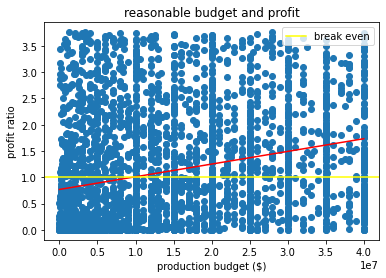

In [58]:

average= budngross[(budngross['production_budget'] <= 40000000) & (budngross['profit_ratio'] <= 3.76)]
x= average['production_budget']
y= average['profit_ratio']
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color= 'red')
plt.axhline(1,color= 'yellow', label= 'break even')
plt.title('reasonable budget and profit')
plt.xlabel('production budget ($)')
plt.ylabel('profit ratio')
plt.legend()
plt.savefig('viz1.png')
plt.show()

The general trend seems to be that the more one invests in the prodcution, the more profit earned. Moreover, the point of intersection between the trend line and the break even line seems to be at around a production budget of 1*10^7 dollars.
### Recommendation 1: invest upwards of 10 million dollars into the production to minimize the chances of a net loss
Caveat: do notice however that the data points are very scattered, and the correlation, while there, seems to be quite  weak.

## Genre and success
Next I will investigate the success of different gernes over the years; In this part I will be measuring success by box office earnings.


In [37]:
# for the purposes of this analysis I will drop the movies that do not have box office information
#then I will convert the numbers into integers
movieinfo= movieinfo.fillna(0)
movieinfo_money = movieinfo[(movieinfo['box_office'] !=0)]
movieinfo_money['genre']= movieinfo_money['genre'].map(lambda x: x.split('|'))
movieinfo_money['box_office']= movieinfo_money['box_office'].map(lambda x: int(x.replace(',','')) if type(x)==str else x)

C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\727650685.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieinfo_money['genre']= movieinfo_money['genre'].map(lambda x: x.split('|'))
C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\727650685.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieinfo_money['box_office']= movieinfo_money['box_office'].map(lambda x: int(x.replace(',','')) if type(x)==str else x)


In [53]:
#Next, I will select the top 5 most frequently made movies, since these movies would have sufficient data points
#for more accurate results
#my strategy is to create a function to split off the genres from the series of lists, keep track of their frequency
#of occurence and weed out the top 5 genres
def top_5(series):
    frequency= {}
    for item in list(series):
        if type(item) == list:
            for i in range(0,len(item)):
                genre =item[i]
                if genre not in frequency.keys():
                    frequency[genre] = 1
                else:
                        frequency[genre] += 1
    top_5_freq= sorted(list(frequency.values()))[-5:]
    top_5_genres=[]
    for g in list(frequency.keys()):
        if frequency[g] in top_5_freq:
            top_5_genres.append(g)
    return top_5_genres
    return frequency

            
top_5_genres= top_5(movieinfo_money['genre'])

In [39]:
#next, extract year from the date column
movieinfo_money['year']= movieinfo_money['dvd_date'].map(lambda x: int(x.split(',')[-1]) if type(x) == str else 0)

C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\4231945354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieinfo_money['year']= movieinfo_money['dvd_date'].map(lambda x: int(x.split(',')[-1]) if type(x) == str else 0)


In [40]:
#create column that indicates if a movie is one of the five genres

for i in range(0,5):
    genre= top_5_genres[i]
    movieinfo_money[genre] = movieinfo_money['genre'].map(lambda x: genre in x)
    

C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\831083056.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieinfo_money[genre] = movieinfo_money['genre'].map(lambda x: genre in x)
C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\831083056.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieinfo_money[genre] = movieinfo_money['genre'].map(lambda x: genre in x)
C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\831083056.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [41]:
#to analyse the success trends of the 5 genres over time, I made a function to calculate the mean of all box office 
#earnings of each genre released in the same year and since we are mainly 
#interested in current trends, I will select movies released since year 2000
def sortt(table):
    df = table.sort_values('year')
    df=df[(df['year']>=2000)]
    grouped = df.groupby('year').mean()
    return grouped
        

In [42]:
#create a table for each genre and apply the function

#Action and Adv
table1= movieinfo_money[movieinfo_money[top_5_genres[0]] == True][['year','box_office']]
I= sortt(table1)['box_office']


#Drama
table2= movieinfo_money[movieinfo_money[top_5_genres[1]] == True][['year','box_office']]
II= sortt(table2)['box_office']

#Mystery and suspense
table3= movieinfo_money[movieinfo_money[top_5_genres[2]] == True][['year','box_office']]
III= sortt(table3)['box_office']


#Comedy
table4= movieinfo_money[movieinfo_money[top_5_genres[3]] == True][['year','box_office']]
IV= sortt(table4)['box_office']


#Art House and international
table5= movieinfo_money[movieinfo_money[top_5_genres[4]] == True][['year','box_office']]
V= sortt(table5)['box_office']


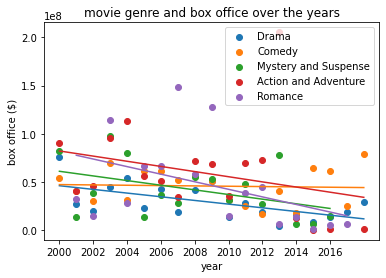

In [57]:
#top 5 genre and box office for the past 20 years (rotten tomatoes) ver 1
plt.scatter(I.index, list(I) ,label = top_5_genres[0])
z1 = np.polyfit(I.index, list(I), 1)
p1 = np.poly1d(z1)
plt.plot(I.index, p1(I.index))
plt.scatter(II.index, list(II), label = top_5_genres[1])
z2 = np.polyfit(II.index, list(II), 1)
p2 = np.poly1d(z2)
plt.plot(II.index, p2(II.index))
plt.scatter(III.index,list(III), label = top_5_genres[2])
plt.scatter(IV.index, list(IV), label = top_5_genres[3])
z3 = np.polyfit(III.index, list(III), 1)
p3 = np.poly1d(z3)
plt.plot(III.index, p3(III.index))
z4 = np.polyfit(IV.index, list(IV), 1)
p4 = np.poly1d(z4)
plt.plot(IV.index, p4(IV.index))
plt.scatter(V.index,list(V),label= top_5_genres[4])
z5 = np.polyfit(V.index, list(V), 1)
p5 = np.poly1d(z5)
plt.plot(V.index, p5(V.index))
plt.xticks(range(2000,2018,2))
plt.title('movie genre and box office over the years')
plt.xlabel('year')
plt.ylabel('box office ($)')
plt.legend()
plt.savefig('viz2-1.png')
plt.show()

looks like comedy and action are the top two genres, but let's further investigate if the release time matters 

In [44]:
import calendar

In [45]:
comedy= movieinfo_money[movieinfo_money['Comedy'] == True]

action= movieinfo_money[movieinfo_money['Action and Adventure'] == True]

comedy['month']= pd.to_datetime(comedy['theater_date']).dt.month

action['month']= pd.to_datetime(action['theater_date']).dt.month

C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\1375748675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comedy['month']= pd.to_datetime(comedy['theater_date']).dt.month
C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\1375748675.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action['month']= pd.to_datetime(action['theater_date']).dt.month


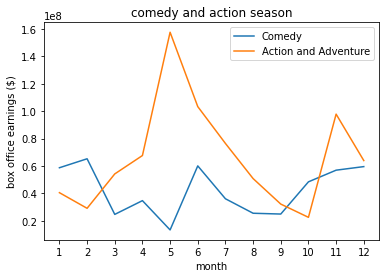

In [56]:
#sort genres by month and take the mean of box office earnings for action and comedy
plt.plot(comedy.groupby('month')['box_office'].mean(), label= 'Comedy')
plt.plot(action.groupby('month')['box_office'].mean(), label = 'Action and Adventure')
plt.xticks(range(1,13,1))
plt.title('comedy and action season')
plt.xlabel('month')
plt.ylabel('box office earnings ($)')
plt.legend()
plt.savefig('viz2-2.png')
plt.show()


It looks like comedy is the only genre on an upward trend in terms of earnigns, but the top genre until 2013 seems to be action and adventure, moreover, there are certain times of the year where the genres are more popular
### Recommendation 2: make a comedy or action movie. If it's an action movie, release during June and November, and if it's a comedy, release durin februrary, june or december.


## runtime and revenue
Finally, I will look into the relationship between the length of the movie and the box office earnings

In [47]:
#make a column that indicates the runtime in terms of minutes, rounding to the nearest 10 minutes
movieinfo_money['mins']= movieinfo_money['runtime'].map(lambda x: int(x.split()[0]) if x!=0 else x).round(-1)

C:\Users\beatr\AppData\Local\Temp\ipykernel_25028\2036177363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieinfo_money['mins']= movieinfo_money['runtime'].map(lambda x: int(x.split()[0]) if x!=0 else x).round(-1)


In [48]:
#function that takes the mean box office grouped by runtime
def sortmins(table):
    df = table.sort_values('mins')
    df= df[(df['mins'] != 0) & (df['box_office'] !=0)]
    grouped = df.groupby('mins').mean()
    return grouped
        


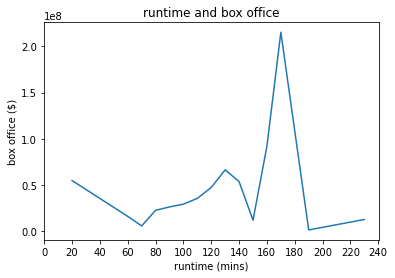

In [55]:
#plot earnings against runtime and label the peak
minsandmoney= sortmins(movieinfo_money[['mins','box_office']])
plt.plot(minsandmoney)
plt.title('runtime and box office')
plt.xlabel('runtime (mins)')
plt.ylabel('box office ($)')
plt.xticks(range(0,250,20))
plt.show()

In [50]:
movieinfo_money.groupby('mins').count()['id']

mins
0       2
20      1
60      1
70      4
80     21
90     68
100    78
110    58
120    60
130    28
140     9
150     2
160     4
170     2
190     1
230     1
Name: id, dtype: int64

Looks like it peaks at 170 minutes, however, there are only two data points for that time frame, therefore the mean of the box office earnings is probably not a good representation for all movies that are around 170 minutes long. Since there are the most amount of data points between 80 and 140 minutes, it would be wise to focus on that range.


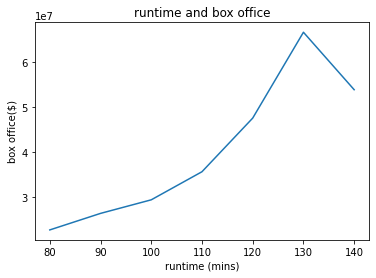

In [54]:
majority = minsandmoney[(minsandmoney.index >=80) & (minsandmoney.index <=140)]
plt.plot(majority)
plt.title('runtime and box office')
plt.xlabel('runtime (mins)')
plt.ylabel('box office($)')
plt.savefig('viz3.png')
plt.show()

there seems to be an exponential increase in earnings up until 130 minutes.
### Recommendation 3: keep the movie between 120 and 130 minutes long 

##Conclusion

1. Liberally invest into the production of the movie
2. Make an Action/ Comedy movie
3. Keep the movie around 130 minutes

###Caveats
These recommendations were based on the overall highest probability of earning the most amount of revenue from the pool of samples I was able to obtain from two credible movie sites. However, these only provide general guidance that highlight the characteristics that successful movies tend to have, and one must keep in mind that correlation does not necessarily mean causation. Moreover, there are also many more factors that contribute to success that I was not able to address, like the plot structure and actors to hire. Regardless, I hope the information provided was usefull for giving one a good guage of what the movie industry is currently like, and its most apparent trends.
